# Starting comments
Charles Le Losq, Created 7 April 2015 for Python, Modified 23 Feb. 2016 for Julia

This IJulia notebook is aimed to show how you can easily fit a Raman spectrum with Julia , for free and, in my opinion, in an elegant way. Julia presents some advantages over Python (speed, in my opinion more simplicity as it is directly made for scientific computing) and inconvenients (young, so may have breakups, not that much libraries). But it is definitely worth the try. For optimisation I think the JuMP package does a really good job, leaving you lots of choice for your optimisation setup and algorithm.

The following fitting procedure phylosophie is totally in contradiction with most existing GUI softwares. It probably is a little bit harder to learn for the newcomer, but you have full control over the procedure.

In this example, we will fit the 850-1300 cm$^{-1}$ portion of a Raman spectrum of a lithium tetrasilicate glass Li$_2$Si$_4$O$_9$, the name will be abbreviated LS4 in the following. 

For further references for fitting Raman spectra of glasses, please see for instance: Virgo et al., 1980, Science 208, p 1371-1373; Mysen et al., 1982, American Mineralogist 67, p 686-695; McMillan, 1984, American Mineralogist 69, p 622-644; Mysen, 1990, American Mineralogist 75, p 120-134; Le Losq et al., 2014, Geochimica et Cosmochimica Acta 126, p 495-517 and Le Losq et al., 2015, Progress in Earth and Planetary Sciences 2:22.

We will use the optimization algorithms of Ipopt with JuMP. Please consult http://www.juliaopt.org/ for further details.

# Importing libraries
So the first part will be to import a bunch of libraries for doing various things (quite straightforward with Julia)

In [1]:
using JuMP
using PyPlot
using Ipopt
using Spectra
using JLD

# Importing and looking at the data
Let's first have a look at the spectrum

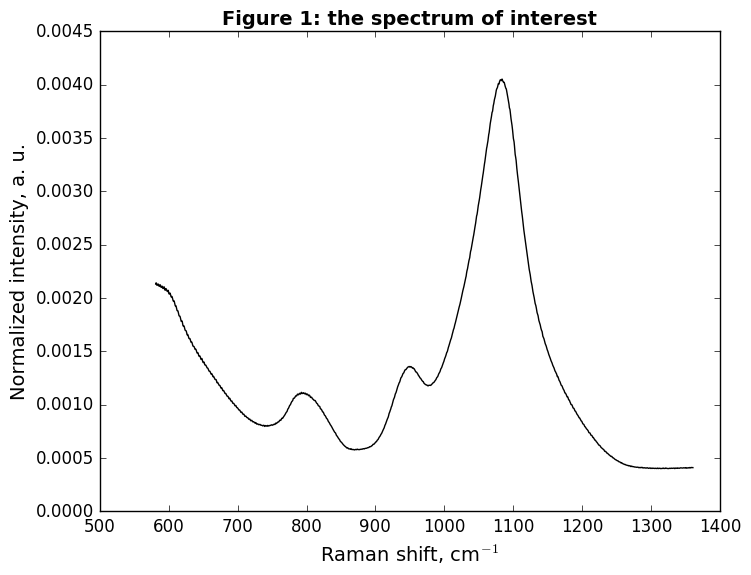

PyObject <matplotlib.text.Text object at 0x31e27f390>

In [2]:
# get the spectrum to deconvolute, with skipping header and footer comment lines from the spectrometer
data = readdlm("./data/LS4.txt", '\t')

# To skip header and footer lines
skip_header = 23
skip_footer = 121
inputsp = zeros(size(data)[1]-skip_header-skip_footer,2)
j = 1
for i = skip_header+1:size(data)[1]-skip_footer
    inputsp[j,1] = Float64(data[i,1])
    inputsp[j,2] = Float64(data[i,2])
    j = j + 1
end

# performing the long correction; not always necessary at frequencies > 500 cm-1, 
# but this is just for the sack of example in the present case
inputsp[:,1], inputsp[:,2],~ = tlcorrection(inputsp,23.0,490.0)

# create a new plot for showing the spectrum
figure()

plot(inputsp[:,1],inputsp[:,2],color="black")

xlabel(L"Raman shift, cm$^{-1}$", fontsize = 14)
ylabel("Normalized intensity, a. u.", fontsize = 14)
title("Figure 1: the spectrum of interest",fontsize = 14, fontweight = "bold")

So we are looking at the 500-1300 cm$^{-1}$ portion of the Raman spectrum of the glass. We see a peak near 800 cm$^{-1}$, and two others near 950 and 1085 cm$^{-1}$. We will be interested in fitting the 870-1300 cm$^{-1}$ portion of this spectrum, which can be assigned to the various symmetric and assymetric stretching vibrations of Si-O bonds in the SiO$_2$ tetrahedra present in the glass network (see the above cited litterature for details).


# Baseline Removal

First thing we notice in Fig. 1, we have to remove a baseline because this spectrum is shifted from 0 by some "background" scattering. This quite typical in Raman spectra of glasses. Several ways exist to do so. We're going to the simplest thing: a polynomial fitting the signal base around 870 and 1300 cm$^{-1}$. Other reasonnable solutions include a linear function, and a constant function. The two latter can be fitted between 1300 and 1350 cm$^{-1}$, but we will need to add another peak around 800 cm$^{-1}$. For now, the example is done with fitting the 870 cm$^{-1}$ portion of spectra, as this usually results in more robust final results.



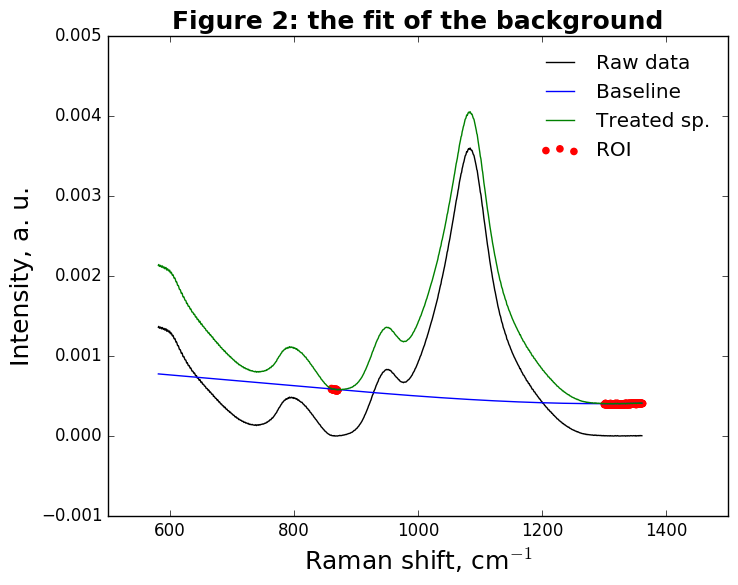

PyObject <matplotlib.legend.Legend object at 0x3216e4450>

In [4]:
# the regions of interest roi
roi = [860.0 870.0; 1300.0 1400.0]


y_corr, y_bas, xy_roi = baseline(inputsp[:,1],inputsp[:,2],roi,"gcvspline",p=0.5,roi_out = "yes") 

#Creates a plot showing the baseline
figure()
plot(inputsp[:,1],y_corr[:,1],color="black",label="Raw data")
scatter(xy_roi[:,1],xy_roi[:,2],color="red",label="ROI")
plot(inputsp[:,1],y_bas[:,1],color="blue",label="Baseline")
plot(inputsp[:,1],inputsp[:,2],color="green",label="Treated sp.")

title("Figure 2: the fit of the background",fontsize = 18, fontweight = "bold")

# we set the values of the labels of the x and y axis.
xlabel(L"Raman shift, cm$^{-1}$",fontsize=18) # The L in front of the string indicates that we use Latex for the maths
ylabel("Intensity, a. u.",fontsize=18)

# we display the legend at the best location, without a frame
legend(loc="best",frameon=false)

Now we will do some manipulation to have the interested portion of spectrum in a single variable. We will assume that the errors have not been drastically affected by the correction process (in some case it can be, but this one is quite straightforward), such that we will use the initial relative errors stored in the "ese0" variable.

In [5]:
index_interest = find(867.0 .< inputsp[:,1] .< 1300.0)

interestspectra = y_corr[index_interest,1]
ese0 = sqrt(abs(interestspectra[:,1]))/abs(interestspectra[:,1]) # the relative errors after baseline subtraction
interestspectra[:,1] = interestspectra[:,1]/trapz(inputsp[index_interest,1],interestspectra[:,1])*100 # normalise spectra to maximum intensity, easier to handle 

# First we simplify things by calling x, y and the frequency and intensity of spectra for later use
sigma = abs(ese0.*interestspectra[:,1]) #calculate good ese
x = inputsp[index_interest,1]
y = interestspectra[:,1]
println("Done")

Done


# Fitting the spectrum

All the fitting will be done using JuMP, and the Ipopt solver. Good thing, you can change the solver as you want. JuMP is just a way to express things (a little bit like lmfit under python, but much more flexible).

There was a long speach at this point in the Python version of this notebook, but Julia allows to fit very easily the spectrum. It is quite obvious in the following lines that we create a model, we define the variables containing the peaks amplitudes, frequency and widths (hwhm), and we set them. 

If more or less peaks are needed, simply change the number of peaks (variable m), and adjust the initial parameters after the setValue function calls.

Constraints are possible to implement too, quite easily. Usually Ipopt gives a very good results without needing constraints.

In [6]:
#Change the following parameters to adjust the model
amp_guess = [1,1,1,1,1]
freq_guess = [950,1050,1090,1140,1190]
hwhm_guess = [30,30,30,30,30]

# we need to know the number of data points as well as the number of peaks
n = size(x)[1] # number of data
m = 5 #number of peaks, to be modified!

# The model for fitting baseline to roi signal
mod = Model(solver=IpoptSolver())
#mod = Model(solver=MosekSolver())
# we declare three variable arrays that contain the amplitudes, frequencies and width of peaks
@variable(mod,g_amplitudes[i=1:m] >= 0.0) # we can add constrain during declaration: the amplitude cannot be negative
@variable(mod,850 <= g_frequency[i=1:m] <= 1250)
@variable(mod,20.0 <= g_hwhm[i=1:m] <= 50) # and we retrain the width to a reasonnable amount

# setting initial values
setvalue(g_amplitudes[i=1:m],amp_guess[i])
setvalue(g_frequency[i=1:m],freq_guess[i])
setvalue(g_hwhm[i=1:m],hwhm_guess[i])

# add constraint
@NLconstraint(mod, freq_g1[j=1:n], 850 <= g_frequency[1] <= 980)
@NLconstraint(mod, freq_g2[j=1:n], 980 <= g_frequency[2] <= 1065)
@NLconstraint(mod, freq_g3[j=1:n], 1065 <= g_frequency[3] <= 1110)
@NLconstraint(mod, freq_g4[j=1:n], 1110 <= g_frequency[4] <= 1170)
@NLconstraint(mod, freq_g5[j=1:n], 1170 <= g_frequency[5] <= 1250)
@NLconstraint(mod, hwhm_g5[j=1:n], 20 <= g_hwhm[5] <= 35)

# here we write the function of our model that allows the direct calculation
@NLexpression(mod,g_mod[j=1:n],sum{g_amplitudes[i] *exp(-log(2) * ((x[j]-g_frequency[i])/g_hwhm[i])^2), i = 1:m})

# Then we write the objective function
@NLobjective(mod,Min,sum{(g_mod[j] - y[j])^2, j=1:n})
println("Constructed")

Constructed


And below, we can launch the fitting procedure:

In [7]:
# Solve for the control and state
println("Solving...")
status = solve(mod)

# Display results
println("Solver status: ", status)
println("rmsd: ", getobjectivevalue(mod))

Solving...

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.1, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:    12990
Number of nonzeros in Lagrangian Hessian.............:      120

Total number of variables............................:       15
                     variables with only lower bounds:        5
                variables with lower and upper bounds:       10
                     variables with only upper bounds:        0
Total num

We can now extract the parameters and the peaks, and plot the results. They speak for themself, no need to adopt a complicated process with first constraining peak frequency for instance, as it was necessary to do in Python.

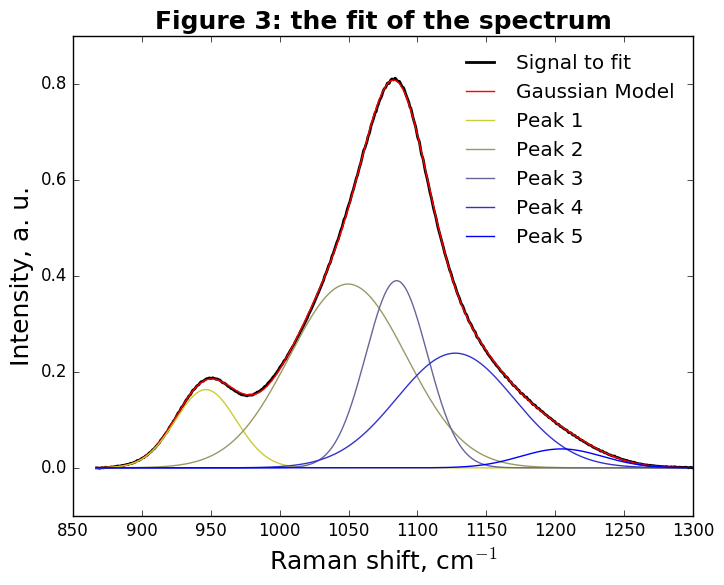


Amplitude are [0.1629562144365243,0.3828739854168505,0.38987727384130494,0.23888263129789192,0.03940614157055891];
Frequency are [946.3798603663854,1049.6125171710974,1084.909352365429,1127.4387553781469,1204.5307985978159];
HWHM are [26.11189253444922,49.99998245068279,26.27392793809149,49.999918451749714,34.882598808184326];


In [8]:
# parameter extractions
amplitudes = getvalue(g_amplitudes)
frequency = getvalue(g_frequency)
hwhm = getvalue(g_hwhm)

model_peaks, peaks = gaussiennes(amplitudes,frequency,hwhm,x) # we construct the model representation and the individual peaks

# Doign a new figure
figure()

#we plot the results
plot(x,y,linewidth=2.0,color="black",label="Signal to fit")
plot(x,model_peaks,color="red",label="Gaussian Model")

for i = 1:5
    plot(x,peaks[:,i],color=[1.-i/5.0,1.-i/5.0,i/5.0],label="Peak $(i)")
end

title("Figure 3: the fit of the spectrum",fontsize = 18, fontweight = "bold")

# we set the values of the labels of the x and y axis.
xlabel(L"Raman shift, cm$^{-1}$",fontsize=18) # The L in front of the string indicates that we use Latex for the maths
ylabel("Intensity, a. u.",fontsize=18)

# we display the legend at the best location, without a frame
legend(loc="best",frameon=false)

println("")
println("Amplitude are $(amplitudes);")
println("Frequency are $(frequency);")
println("HWHM are $(hwhm);")
    

I discussed in the python version of this example that changing the algorithm can give you different results. This is quite true. The good thing is that JuMP just allows you to implement your model. You can change the solver and algorithm without any further difficulty when declaring the model:
    mod = Model(solver=IpoptSolver(print_level=0))
Very different solvers are available in Julia, and you can choose looking here: http://www.juliaopt.org/

Ipopt seems to be pretty good and should fit the needs of most problems quite well. But there is also NLopt, in which you can choose to use the Nelder-Mead algorithm for instance, or Mosek. 


# Error estimation with bootstrapping

Estimation of the errors affecting each parameter will be done with bootstrapping. We first resample with replacement X times our dataset. Then we fit it X times and we save the X parameter sets generated. With X large enough, this provides a robust statistic for the errors on the parameters.

In [9]:
nb_boot = 500 # times we do the bootstrap

params_boot = Array{Float64}(nb_boot,3,m) # for recording the parameters generated

for k = 1:nb_boot # bootstrapping loop
    
    b_x_f, b_y_f = bootsample(x,y) #resampling data with replacement with Spectra.jl bootsample function
    
    mod2 = Model(solver=IpoptSolver(print_level=0))# The model for fitting baseline to roi signal
    
    @variable(mod2,g_amplitudes_b[i=1:m] >= 0.0)
    @variable(mod2,850 <= g_frequency_b[i=1:m] <= 1250)
    @variable(mod2,20.0 <= g_hwhm_b[i=1:m] <= 50.0)

    # setting initial values
    setvalue(g_amplitudes_b[i=1:m],amp_guess[i])
    setvalue(g_frequency_b[i=1:m],freq_guess[i])
    setvalue(g_hwhm_b[i=1:m],hwhm_guess[i])
    
    # set bounds
    setupperbound(g_hwhm_b[3], 35.0 )
    setupperbound(g_hwhm_b[5], 45.0 )
    setlowerbound(g_frequency_b[5], 1160 )
    
    @NLexpression(mod2,g_mod_b[j=1:n],sum{g_amplitudes_b[i] *exp(-log(2) * ((b_x_f[j]-g_frequency_b[i])/g_hwhm_b[i])^2), i = 1:m})
    @NLobjective(mod2,Min,sum{(g_mod_b[j] - b_y_f[j])^2, j=1:n})
    status = solve(mod2)
    println("Iteration $(k), solver status: ", status) # we print some information
    
    params_boot[k,1,:] = getvalue(g_amplitudes_b)
    params_boot[k,2,:] = getvalue(g_frequency_b)
    params_boot[k,3,:] = getvalue(g_hwhm_b)
end
        

println("Done...")

Iteration 1, solver status: Optimal
Iteration 2, solver status: Optimal
Iteration 3, solver status: Optimal
Iteration 4, solver status: Optimal
Iteration 5, solver status: Optimal
Iteration 6, solver status: Optimal
Iteration 7, solver status: Optimal
Iteration 8, solver status: Optimal
Iteration 9, solver status: Optimal
Iteration 10, solver status: Optimal
Iteration 11, solver status: Optimal
Iteration 12, solver status: Optimal
Iteration 13, solver status: Optimal
Iteration 14, solver status: Optimal
Iteration 15, solver status: Optimal
Iteration 16, solver status: Optimal
Iteration 17, solver status: Optimal
Iteration 18, solver status: Optimal
Iteration 19, solver status: Optimal
Iteration 20, solver status: Optimal
Iteration 21, solver status: Optimal
Iteration 22, solver status: Optimal
Iteration 23, solver status: Optimal
Iteration 24, solver status: Optimal
Iteration 25, solver status: Optimal
Iteration 26, solver status: Optimal
Iteration 27, solver status: Optimal
Iteration 

When this is done, we can save the params_boot matrix somewhere in the system with JLD, the Julia file format. We could also output it as a .txt file to use it with another program for plotting, for instance. Then we construct an array that looks at how the parameter std changes during the bootstrapping, for instance. When stable, we can assume we did enought bootstrap to get good results.

In [10]:
save("./data/Raman_fitting_example_results.jld","params_boot",params_boot) # saving the results with JLD

for i = 1:m
    println("From bootstrapping, values for peak $(i):")
    println("Amplitude mean $(mean(params_boot[:,1,i],1)) and std $(std(params_boot[:,1,i],1))")
    println("Raman shift (cm^{-1}) mean $(mean(params_boot[:,2,i],1)) and std $(std(params_boot[:,2,i],1))")
    println("HWHM (cm^{-1}) mean $(mean(params_boot[:,3,i],1)) and std $(std(params_boot[:,3,i],1))")
    println("")
end

# bootstrap performance recorder
bootrecord = zeros(nb_boot,3,m)
for k = 1:nb_boot
    for j = 1:3
    for i = 1:m
        if k == 1
            bootrecord[k,j,i] = 0.0
        else
            bootrecord[k,j,i] = sum(std(params_boot[1:k,j,i],1))
        end
    end
    end
end

From bootstrapping, values for peak 1:
Amplitude mean [0.16277538348359152] and std [0.0013142744052825257]
Raman shift (cm^{-1}) mean [946.2836997501611] and std [0.12724901788482743]
HWHM (cm^{-1}) mean [26.005816923024664] and std [0.1271214203513715]

From bootstrapping, values for peak 2:
Amplitude mean [0.3886264662634035] and std [0.018349621938715456]
Raman shift (cm^{-1}) mean [1049.5514277110399] and std [2.6738331085367713]
HWHM (cm^{-1}) mean [49.99993665926869] and std [5.705740485480358e-6]

From bootstrapping, values for peak 3:
Amplitude mean [0.5055984934227445] and std [0.026446651110808815]
Raman shift (cm^{-1}) mean [1087.03008929969] and std [0.34511278437194304]
HWHM (cm^{-1}) mean [28.057297018856335] and std [0.5295535836869644]

From bootstrapping, values for peak 4:
Amplitude mean [0.13186098827231427] and std [0.032391113060556496]
Raman shift (cm^{-1}) mean [1134.8780767082924] and std [4.148162510226872]
HWHM (cm^{-1}) mean [28.269184174536118] and std [3.1

We can now look at the bootstrapping results. param_interest_boot_stat allows you to choose the parameter you want to look at (1 for amplitude, 2 for frequency, 3 for HWHM), and peak_interest_boot_stat the peak you want to look at.

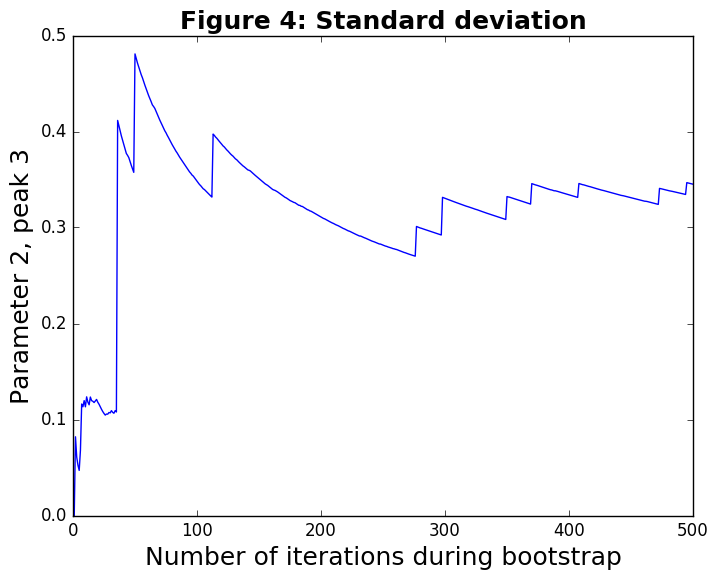

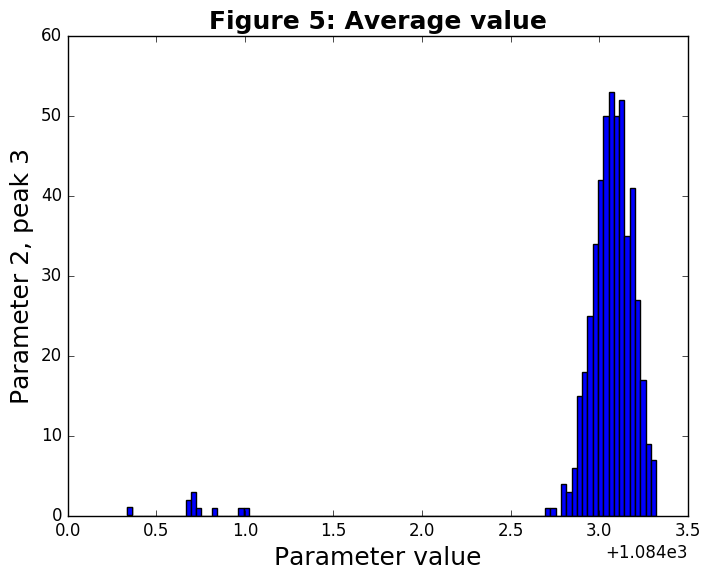

PyObject <matplotlib.text.Text object at 0x321e98850>

In [11]:
# bootstrap performance
param_interest_boot_stat =2
peak_interest_boot_stat = 3

# Graphics
fig = figure()
plot(1:nb_boot, bootrecord[:,param_interest_boot_stat,peak_interest_boot_stat],label="SOI")

title("Figure 4: Standard deviation",fontsize = 18, fontweight = "bold")

xlabel("Number of iterations during bootstrap",fontsize=18)
ylabel("Parameter $(param_interest_boot_stat), peak $(peak_interest_boot_stat)",fontsize=18)

fi2= figure()
h = plt[:hist](params_boot[:,param_interest_boot_stat,peak_interest_boot_stat],100)

title("Figure 5: Average value",fontsize = 18, fontweight = "bold")

xlabel("Parameter value",fontsize=18)
ylabel("Parameter $(param_interest_boot_stat), peak $(peak_interest_boot_stat)",fontsize=18)
